In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state,get_dropbox_folders
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value
)
from matplotlib import cm
import networkx as nx

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/171 [00:00<?, ?it/s]

In [3]:
folders = all_folders.loc[all_folders["medium"].str.contains("Myr")]
folders = folders.loc[folders["/Analysis/nx_graph_pruned.p"] == True]


In [10]:
plates = ["33_20230221"]
folders = all_folders.loc[all_folders["unique_id"] == "33_20230221"]


In [7]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime


In [11]:
folders = folders.sort_values(by="datetime")

i = 0
exp = Experiment(directory_targ)

exp.load(folders.iloc[i:i+1],suffix="")
for t in range(exp.ts):
    exp.load_tile_information(t)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-07 15:47:00


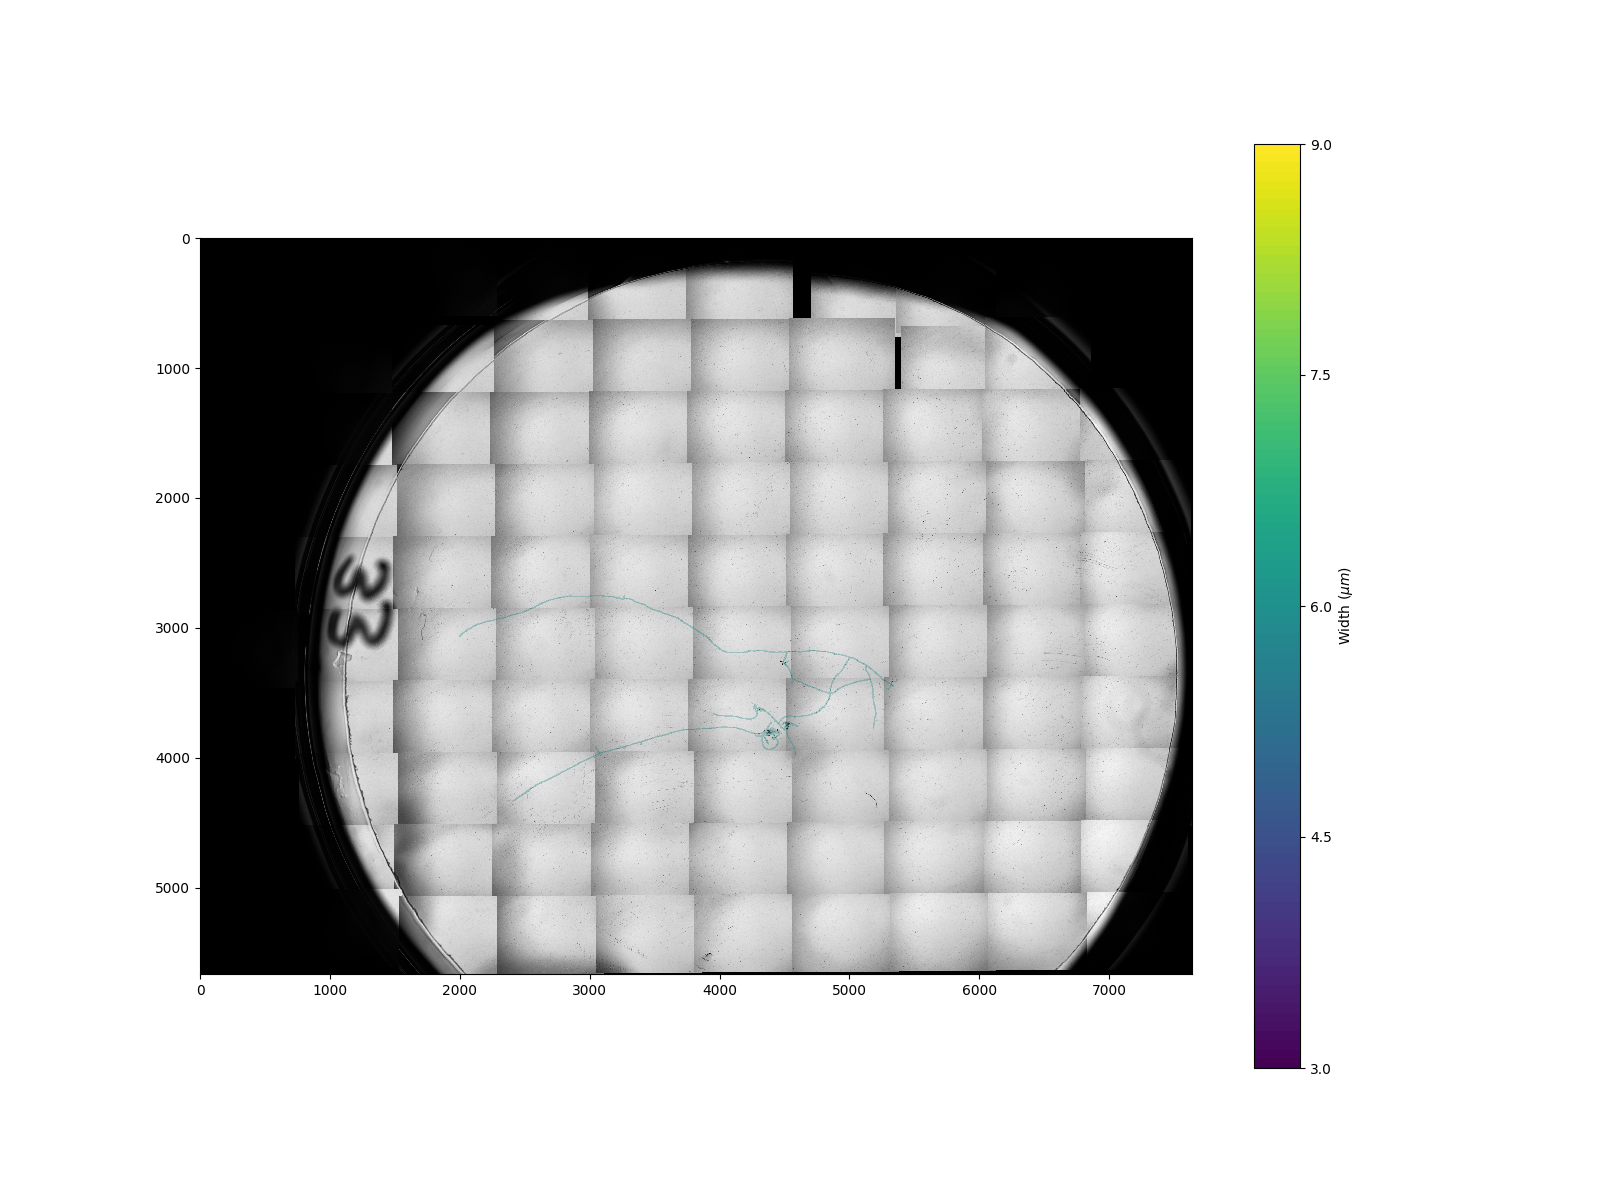

<AxesSubplot:>

In [15]:
vmax = 9
vmin = 3
region = None
nodes = get_all_nodes(exp,t)
plot_edge_color_value(
    exp,
    t,
    lambda edge: 6,
    region = region,
    # nodes = nodes,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=True,
    dilation=10,
    figsize=(16, 12),
    alpha = 0.3,
    downsizing = 5
    
)

In [17]:
get_length_tot(exp,t)

('tot_length', 101236.00211521907)

In [14]:
threshold =0.01
nx_graph = exp.nx_graph[t]
S = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph)]
selected = [g for g in S if g.size(weight="weight") / 10**6 >= threshold]
G = selected[0]
for g in selected[1:]:
    G = nx.compose(G, g)
exp.nx_graph[t] = G


In [38]:
f"images/{folders.iloc[i]['folder']}"

'images/20230504_1501_Plate03'

<AxesSubplot:>

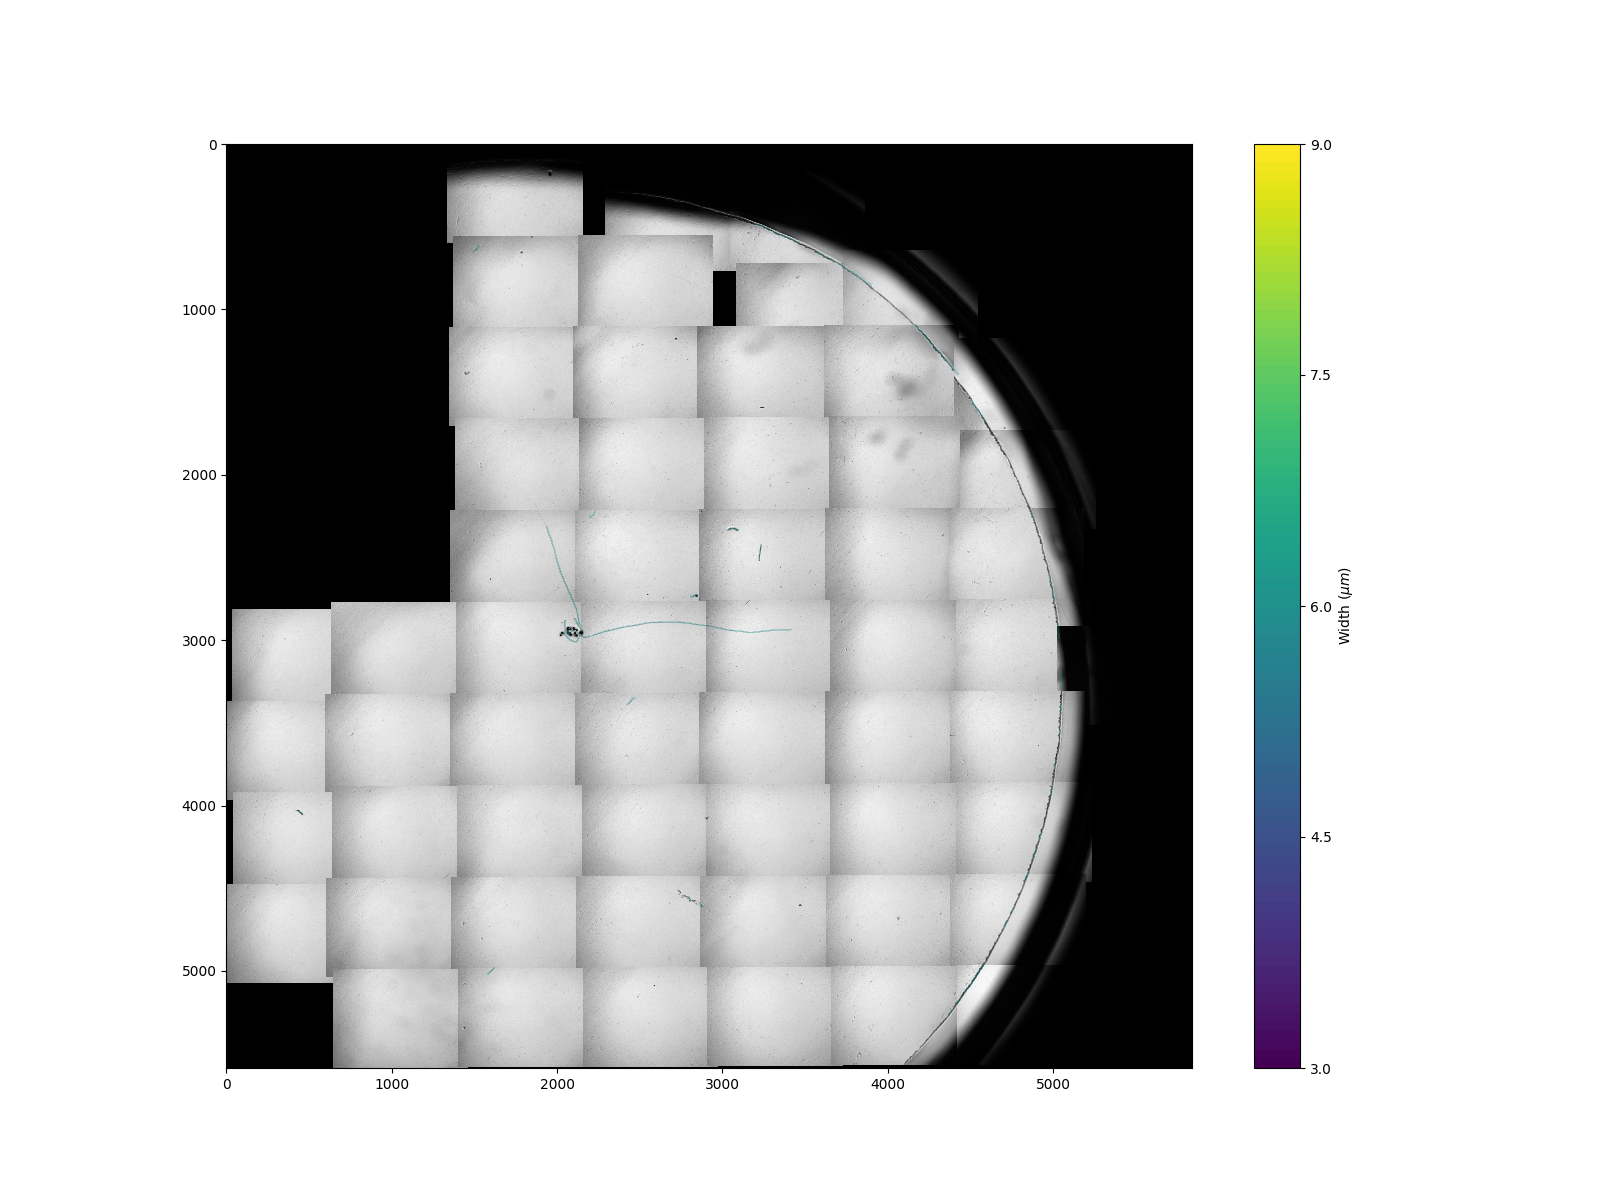

In [42]:
vmax = 9
vmin = 3
region = None
nodes = get_all_nodes(exp,t)
plot_edge_color_value(
    exp,
    t,
    lambda edge: 6,
    region = region,
    # nodes = nodes,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=True,
    dilation=10,
    figsize=(16, 12),
    alpha = 0.3,
    downsizing = 5,
    save_path=f"images/{folders.iloc[i]['folder']}",
    dpi = 150
)

In [4]:
import sys
from amftrack.util.sys import (
    update_analysis_info,
    get_analysis_info,
)
from amftrack.pipeline.launching.run_super import run_parallel_post
from amftrack.pipeline.functions.post_processing.global_plate import *
from amftrack.pipeline.functions.post_processing.time_plate import *
from amftrack.pipeline.functions.post_processing.global_hypha import *
from amftrack.pipeline.functions.post_processing.area_hulls import *
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher
from amftrack.pipeline.functions.post_processing.exp_plot import *


In [5]:

def get_area_separate_connected_components(exp, t, args=None):
    nx_graph = exp.nx_graph[t]
    threshold = 0.1
    S = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph)]
    selected = [
        g for g in S if g.size(weight="weight") * len(g.nodes) / 10**6 >= threshold
    ]
    area = 0
    for g in selected:
        nodes = np.array(
            [
                node.pos(t)
                for node in exp.nodes
                if node.is_in(t)
                and (node.label in g.nodes)
            ]
        )
        if len(nodes) > 3:
            hull = spatial.ConvexHull(nodes)
            poly = Polygon([nodes[vertice] for vertice in hull.vertices])
            area += poly.area * 1.725**2 / (1000**2)
    return ("area_sep_comp", area)

def get_num_edges(exp, t, args=None):
    return (
        "num_edges_study",
        np.sum(
            [
                node.degree(t)
                for node in exp.nodes
                if node.is_in(t)
                and node.degree(t) > 0
            ]
        )
        / 2,
    )

def get_mean_edge_straight(exp, t, args=None):
    (G, pos) = exp.nx_graph[t], exp.positions[t]
    edges = [
        Edge(Node(edge_coord[0], exp), Node(edge_coord[1], exp), exp)
        for edge_coord in list(G.edges)
    ]
    straightnesses = []
    for edge in edges:
        is_in_end = True
        is_in_begin = True
        if is_in_end and is_in_begin:
            length = measure_length_um_edge(edge, t)
            straight_distance = (
                np.linalg.norm(edge.end.pos(t) - edge.begin.pos(t)) * 1.725
            )
            if straight_distance > 40:
                straightnesses.append(straight_distance / length)
    if len(straightnesses) > 0:
        return ("mean_straightness", np.mean(straightnesses))
    else:
        return ("mean_straightness", None)
list_f = [
    get_area,
    get_area_separate_connected_components,
    get_num_tips,
    get_num_nodes,
    get_num_edges,
    get_length_tot,
    get_mean_edge_straight,
]
list_args = [{}] * len(list_f)

In [ ]:
time_plate_info = {}
for i in range(60,len(folders)):
    exp = Experiment(directory_targ)

    exp.load(folders.iloc[i:i+1],suffix="")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    threshold =0.01
    nx_graph = exp.nx_graph[t]
    S = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph)]
    selected = [g for g in S if g.size(weight="weight") / 10**6 >= threshold]
    if len(selected)>0:
        G = selected[0]
        for g in selected[1:]:
            G = nx.compose(G, g)
    else:
        threshold =0.001
        nx_graph = exp.nx_graph[t]
        S = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph)]
        selected = [g for g in S if g.size(weight="weight") / 10**6 >= threshold]
        if len(selected)>0:
            G = selected[0]
            for g in selected[1:]:
                G = nx.compose(G, g)
    exp.nx_graph[t] = G
    row = folders.iloc[i]
    t=0
    data_t = {}
    date = exp.dates[t]
    date_str = datetime.strftime(date, "%d.%m.%Y, %H:%M:")
    try:
        for index, f in enumerate(list_f):
            list_args[index]["op_id"] = 4
            column, result = f(exp, t, list_args[index])
            print(column, result)
            data_t[column] = result
        data_t["date"] = date_str
        data_t["Plate"] = row["Plate"]
        data_t["medium"] = row["medium"]

        data_t["unique_id"] = row["unique_id"]

        time_plate_info[row["folder"]] = data_t
        vmax = 9
        vmin = 3
        region = None
        nodes = get_all_nodes(exp,t)

        plot_edge_color_value(
            exp,
            t,
            lambda edge: 6,
            region = region,
            # nodes = nodes,
            cmap=cm.get_cmap("viridis", 100),
            v_min=vmin,
            v_max=vmax,
            plot_cmap=True,
            show_background=True,
            dilation=10,
            figsize=(16, 12),
            alpha = 0.3,
            downsizing = 5,
            save_path=f"images/{folders.iloc[i]['folder']}",
            dpi = 150
        )
        plt.close("all")
    except:
        pass

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-13 14:20:00
ERROR! Session/line number was not unique in database. History logging moved to new session 5687
area 1161.5321226121875
area_sep_comp 346.78411189031254
num_tips 32
num_nodes 75
num_edges_study 82.0
tot_length 151937.98182565952
mean_straightness 0.9172801075552532


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-24 11:24:00
area 102.22375236750001
area_sep_comp 102.22375236750001
num_tips 26
num_nodes 193
num_edges_study 299.0
tot_length 67401.07356032898
mean_straightness 0.8661427929648446


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-08 09:43:00
area 373.3461415265626
area_sep_comp 354.8554143609376
num_tips 139
num_nodes 1894
num_edges_study 2914.0
tot_length 324267.51265072695
mean_straightness 0.8872940948058483


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-14 11:08:00
area 1568.7181279856252
area_sep_comp 1429.2963850556253
num_tips 1042
num_nodes 16303
num_edges_study 25559.0
tot_length 3242930.554624637
mean_straightness 0.9161332279182591


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-22 13:21:00
area 34.613740591875
area_sep_comp 34.613740591875
num_tips 21
num_nodes 153
num_edges_study 218.0
tot_length 48812.858025889036
mean_straightness 0.8873248466796915


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-28 10:11:00
area 299.65643541000003
area_sep_comp 299.65643541000003
num_tips 509
num_nodes 30256
num_edges_study 47657.0
tot_length 2588865.6491071796
mean_straightness 0.9152773696136264


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-18 11:07:00
area 9.372892919062501
area_sep_comp 0
num_tips 6
num_nodes 6
num_edges_study 3.0
tot_length 11931.943187563382
mean_straightness 0.9915087810219596


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-03 15:35:00
area 62.68698453093751
area_sep_comp 62.68698453093751
num_tips 20
num_nodes 73
num_edges_study 94.0
tot_length 46037.51711126599
mean_straightness 0.8714803958609271


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-12 09:38:00
area 479.85087797156257
area_sep_comp 351.32391285468753
num_tips 109
num_nodes 398
num_edges_study 510.0
tot_length 193488.5660166807
mean_straightness 0.9096194038997404


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-12 09:42:00
area 31.536224240625007
area_sep_comp 31.536224240625007
num_tips 11
num_nodes 20
num_edges_study 19.0
tot_length 19723.756644776222
mean_straightness 0.9632772597248845


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-04-20 09:17:00
area 11.793407636250002
area_sep_comp 0
num_tips 3
num_nodes 5
num_edges_study 4.0
tot_length 24819.354238362506
mean_straightness 0.8960200639867663


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-28 12:13:00
area 746.2674977062501
area_sep_comp 635.0742132665627
num_tips 472
num_nodes 9766
num_edges_study 15448.0
tot_length 1619716.256585878
mean_straightness 0.898050500632552


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-15 13:00:00
area 897.919101045
area_sep_comp 7.5685304559375
num_tips 60
num_nodes 448
num_edges_study 625.0
tot_length 114175.29086439194
mean_straightness 0.8628485945009178


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-03-28 10:10:00
area 1020.1121850065626
area_sep_comp 832.8219048984375
num_tips 860
num_nodes 12374
num_edges_study 19177.0
tot_length 1837842.5012300387
mean_straightness 0.8844869484564999


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-05-12 09:29:00
area 33.9659693465625
area_sep_comp 33.9659693465625
num_tips 8
num_nodes 89
num_edges_study 128.0
tot_length 32749.932916845657
mean_straightness 0.9088797716746655


In [50]:
time_plate_info

{'20230307_1358_Plate01': {'area': 1702.3694035246879,
  'area_sep_comp': 254.74050230906252,
  'num_tips': 252,
  'num_nodes': 3064,
  'num_edges_study': 4751.0,
  'tot_length': 566183.5030076733,
  'mean_straightness': 0.8662640526123293,
  'date': '07.03.2023, 13:58:',
  'Plate': '046',
  'unique_id': '46_20230301'},
 '20230307_1407_Plate01': {'area': 539.8529307721876,
  'area_sep_comp': 0,
  'num_tips': 17,
  'num_nodes': 23,
  'num_edges_study': 17.0,
  'tot_length': 29809.18406489127,
  'mean_straightness': 0.9025456942391581,
  'date': '07.03.2023, 14:07:',
  'Plate': '030',
  'unique_id': '30_20230227'},
 '20230307_1414_Plate01': {'area': 1710.5593233346876,
  'area_sep_comp': 461.529402868125,
  'num_tips': 139,
  'num_nodes': 2301,
  'num_edges_study': 3553.0,
  'tot_length': 386341.5687207603,
  'mean_straightness': 0.857956513388262,
  'date': '07.03.2023, 14:14:',
  'Plate': '016',
  'unique_id': '16_20230227'},
 '20230307_1547_Plate01': {'area': 1894.0468082540626,
  'ar

In [9]:
from amftrack.util.sys import *

with open(f"hannah_data.json", "w") as jsonf:
    print("saving")
    json.dump(time_plate_info, jsonf, indent=4)
data = pd.read_json(f"hannah_data.json").transpose()
data.to_csv(f"hannah_data.csv")

saving


Text(0, 0.5, 'total length ($\\mu m$)')

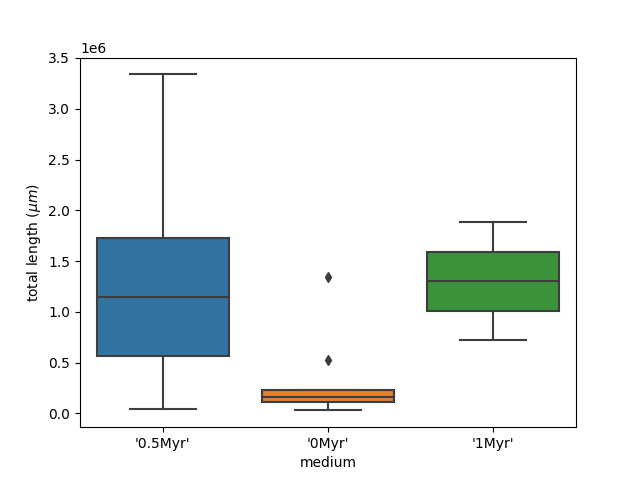

In [79]:
%matplotlib widget

import seaborn as sns
sns.boxplot(data,x="medium",y="tot_length",)
plt.ylabel('total length ($\mu m$)')

In [72]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 30.0 MB/s eta 0:00:00


In [3]:
plates= ['41_20230221',
 '41_20220310',
 '41_20220310',
 '63_20230510',
 '56_20230511',
 '56_20230511',
 '55_20230510',
 '51_20230510',
 '50_20230511',
 '49_20230510',
 '64_20230508',
 '60_20230508',
 '59_20230508',
 '63_20230510',
 '61_20230510',
 '55_20230510',
 '51_20230510',
 '49_20230510',
 '50_20230511',
 '64_20230508',
 '60_20230508',
 '59_20230508',
 '72_20230501',
 '69_20230501',
 '68_20230501',
 '67_20230501',
 '118_20220426',
 '115_20220324',
 '109_20220324',
 '106_20220324',
 '100_20220324',
 '50_20220310',
 '49_20220310',
 'network_extraction',
 '47_20220310',
 '45_20220310',
 '69_20230501',
 '67_20230501',
 '68_20230501',
 '2_20230306',
 '6_20230221',
 '10_20230227',
 '35_20230227',
 '29_20230221',
 '26_20230308',
 '26_20230308',
 '34_20230227',
 '25_20230221',
 '47_20230221',
 '21_20230306',
 '45_20230221',
 '18_20230221',
 '42_20230221',
 '4_20230221',
 '17_20230221',
 '15_20230221',
 '5_20230306',
 '33_20230221',
 '2_20230306',
 '14_20230301',
 '2_20230306',
 'network_extraction',
 '13_20230221',
 '107_20220426',
 '119_20220426',
 '83_20220426',
 '80_20220426',
 '68_20220426',
 '60_20220310',
 '55_20220310',
 '16_20230227',
 '116_20220426',
 '58_20220310',
 '21_20230306',
 '37_20230221',
 '46_20230221',
 '98_2022_0426',
 '110_20220426',
 '14_20230301',
 '14_20230301',
 '48_20230227',
 '48_20230227',
 '48_20230227',
 '13_20230221',
 '74_20220426',
 '34_20230227',
 '31_20230227',
 '01_20230221',
 '16_20230227',
 '30_20230227',
 '10_20230227',
 '33_20230221',
 '46_20230221',
 '62_20220324',
 '57_20220310',
 '101_20220310']